In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.pyplot import pie, axis, show
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

# Load dataset

In [16]:
staff = pd.read_pickle('staff')
unitsS1 = pd.read_pickle('unitsS1')
unitsS2 = pd.read_pickle('unitsS2')
unitsOLE = pd.read_pickle('unitsOLE')
unitsHonors = pd.read_pickle('unitsHonors')

# Definitions

In [17]:
def getUnit(code=None,staff=staff,unitsS1=unitsS1,unitsS2=unitsS2,
             unitsOLE=unitsOLE,unitsHonors=unitsHonors):
    
    viewunit = unitsS1[unitsS1['code']==code] 
    lvl = 'S.1'
    if len(viewunit) == 0:
        viewunit = unitsS2[unitsS2['code']==code] 
        lvl = 'S.2'
    if len(viewunit) == 0:
        viewunit = unitsOLE[unitsOLE['code']==code] 
        lvl = 'OLE'
    if len(viewunit) == 0:
        viewunit = unitsHonors[unitsHonors['code']==code]
        lvl = 'Hon' 
    if len(viewunit) == 0:
        print('Hum... the requested unit is not in the database !')
        return

    sumload = 0.
    load = viewunit['load'].values[0]
    description = viewunit['description'].values[0]
    coordinator = viewunit['coordinator'].values[0]
    
    unit = pd.DataFrame(columns=['code','semester','coordinator',
                                 'staff','weight','cumload','description',
                                 'unitload'])
    
    for k in range(len(staff)):
        
        name = staff['name'].values[k]
        listunits = staff['units'].values[k]
        listperc = staff['perc'].values[k]
        for p in range(len(listunits)):
            if listunits[p] == code:
                sumload += listperc[p]
                unit = unit.append({'code':code,'semester':lvl,'unitload':load,'staff':name,
                                    'description':description,'weight':listperc[p],
                                    'cumload':sumload,'coordinator':coordinator}, 
                                      ignore_index=True)
    
    return unit

def plotUnitGraph(df=None,code=None):
    
    G = nx.from_pandas_edgelist(df, 'code', 'staff', ['weight'])
    pos = nx.circular_layout(G)

    edges = G.edges()
    weights = [G[u][v]['weight']*0.05 for u,v in edges]

    plt.figure(1,figsize=(4,4)) 
    nx.draw_networkx_nodes(G,pos,
                           node_color='k',
                           node_size=4500)
    
    nx.draw_networkx_nodes(G,pos,
                           node_color='#A0CBE2',
                           node_size=4000)
    
    nx.draw_networkx_nodes(G,pos,nodelist=[code],
                           node_color='r',
                           node_size=4000)

    labels = nx.get_edge_attributes(G,'weight')

    nx.draw_networkx_edges(G,pos,
            width=weights, edge_cmap=plt.cm.Blues, with_labels=True)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw_networkx_labels(G,pos,font_size=11)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return

In [18]:
def createGraph(units=None):
    
    tmp = units.copy()
    tmp = tmp.rename(columns = {'weight':'staffweight'})
    tmp = tmp.rename(columns = {'cumload':'weight'})
    G = nx.from_pandas_edgelist(tmp, 'school', 'code', ['weight'])
    
    # Create first nodes representing the units
    node_list = sorted(G.nodes())
    val = filter(lambda a: a != 'GEOS', node_list)
    angle = []
    angle_dict = {}
    n = len(val)
    for i, node in zip(xrange(n),val):
        theta = 2.*np.pi*i/n
        angle.append((np.cos(theta)*0.75,np.sin(theta)*0.75))
        angle_dict[node] = theta

    pos = {}
    for node_i, node in enumerate(val):
        pos[node] = angle[node_i]
    pos['GEOS'] = (0.0, 0.0)
    
    # Then the second ones corresponding to the staff
    node_list2 = np.arange(len(val)*5)
    angle2 = []
    angle2_dict = {}
    n = len(val)*5
    for i, node in zip(xrange(n),node_list2):
        theta = 2.*np.pi*i/n
        angle2.append((np.cos(theta)*1.25,np.sin(theta)*1.25))
        angle2_dict[node] = theta

    pos2 = {}
    for node_i, node in enumerate(node_list2):
        pos2[node] = angle2[node_i]

    # Define the position of the staff 'nodes'
    p = len(val)*5-2
    c = 0
    pos3 = {}
    staffname = {}
    for k in range(len(val)):
        df = getUnit(val[k])
        count = df['staff'].count()
        if count == 0:
            id = [-1]
        if count == 1:
            id = [2]
        if count == 2:
            id = [1,3]
        if count == 3:
            id = [0,2,4]
        if count == 4:
            id = [0,1,2,3]
        if count == 5:
            id = [0,1,2,3,4]
        if count > 5:
            print("hoops! more than 5 lecturers in the following unit:",val[k])
        j = 0
        for i in range(5):
            if i in id:   
                pos3[c] = pos2[p]
                staffname[c] = df['staff'][j]
                G.add_node(c,pos=pos2[p])
                G.add_edge(val[k],c,weight=df['weight'][j])
                j += 1
                c += 1
            if p == len(val)*5-1:
                p = 0
            else:
                p += 1
    totpos = pos.copy()
    totpos.update(pos3)  
    
    labeldict = {}
    for k in range(len(node_list)):
        labeldict[node_list[k]] = node_list[k]
    labeldict['GEOS'] = 'GEOS'

    labeldict = {}
    for k in range(len(node_list)):
        labeldict[node_list[k]] = node_list[k]
    labeldict['GEOS'] = 'GEOS'

    pos4 = pos3.copy()
    for key in pos4.keys():
        pos4[key] = map(lambda x: x*1.08, pos4.get(key))
        
    return G,totpos,pos,pos4,val,staffname,labeldict

def viewGraph(G, pos, unitpos, staffpos, nodelist, staffname, labeldict, figname=None):
    
    fig, ax = plt.subplots(1,figsize=(12,12)) 

    margin=0.33
    fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
    ax.axis('equal')

    # pos,unitpos,staffpos,nodelist,staffname

    nx.draw_networkx_nodes(G,pos,
                           node_color='k',
                           node_size=150)
    nx.draw_networkx_nodes(G,pos,
                           node_color='#e05cab',
                           node_size=140)
    nx.draw_networkx_nodes(G,pos,nodelist=nodelist,
                           node_color='k',
                           node_size=2100)
    nx.draw_networkx_nodes(G,pos,nodelist=nodelist,
                           node_color='#5eed9a',
                           node_size=2000)
    nx.draw_networkx_nodes(G,pos,nodelist=['GEOS'],
                           node_color='k',
                           node_size=2500)
    nx.draw_networkx_nodes(G,pos,nodelist=['GEOS'],
                           node_color='#699ce0',
                           node_size=2400)
    edges = G.edges()

    weights = [G[u][v]['weight']*0.03 for u,v in edges]
    elabels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

    nx.draw_networkx_edges(G, pos, width=weights, with_labels=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=elabels, font_size=7)
    nx.draw_networkx_labels(G, unitpos, font_size=8, labels=labeldict)
    nx.draw_networkx_labels(G, staffpos, font_size=8, labels=staffname)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.tight_layout()
    if figname is not None:
        fig.savefig(figname,dpi=400)
    plt.show()
    
    return

# Single unit allocation

,code,semester,coordinator,staff,weight,cumload,description,unitload
0,MARS5004,S.2,Vila-Concejo,Bruce,25,25,Coastal Management Field School,100
1,MARS5004,S.2,Vila-Concejo,Dominey-Howes,25,50,Coastal Management Field School,100
2,MARS5004,S.2,Vila-Concejo,Cowell,50,100,Coastal Management Field School,100


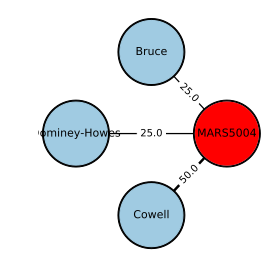

In [19]:
code = 'MARS5004'
df = getUnit(code)
#print df['cumload'].max()
display(HTML(df.to_html()))
plotUnitGraph(df,code)

# All units load

Merge all units together

In [20]:
units1 = pd.DataFrame(columns=['school','code','staff','lvl','weight','cumload'])
units2 = pd.DataFrame(columns=['school','code','staff','lvl','weight','cumload'])
unitsO = pd.DataFrame(columns=['school','code','staff','lvl','weight','cumload'])
unitsH = pd.DataFrame(columns=['school','code','staff','lvl','weight','cumload'])

for k in range(len(unitsS1)):
    code = unitsS1['code'][k]
    df = getUnit(code)
    for p in range(len(df)):
        units1 = units1.append({'school':'GEOS','code':df['code'][p],
                                    'staff':df['staff'][p],'lvl':'S.1','weight':df['weight'][p],
                                    'cumload':df['cumload'][p]},ignore_index=True)
for k in range(len(unitsS2)):
    code = unitsS2['code'][k]
    df = getUnit(code)
    for p in range(len(df)):
        units2 = units2.append({'school':'GEOS','code':df['code'][p],
                                    'staff':df['staff'][p],'lvl':'S.2','weight':df['weight'][p],
                                    'cumload':df['cumload'][p]},ignore_index=True)
for k in range(len(unitsOLE)):
    code = unitsOLE['code'][k]
    df = getUnit(code)
    for p in range(len(df)):
        unitsO = unitsO.append({'school':'GEOS','code':df['code'][p],
                                    'staff':df['staff'][p],'lvl':'OLE','weight':df['weight'][p],
                                    'cumload':df['cumload'][p]},ignore_index=True)
for k in range(len(unitsHonors)):
    code = unitsHonors['code'][k]
    df = getUnit(code)
    for p in range(len(df)):
        unitsH = unitsH.append({'school':'GEOS','code':df['code'][p],
                                    'staff':df['staff'][p],'lvl':'Hon','weight':df['weight'][p],
                                    'cumload':df['cumload'][p]},ignore_index=True)
allunits = units1.append(units2,ignore_index=True)
allunits = allunits.append(unitsO,ignore_index=True)
allunits = allunits.append(unitsH,ignore_index=True)
#display(HTML(allunits.to_html()))

### Semester 1

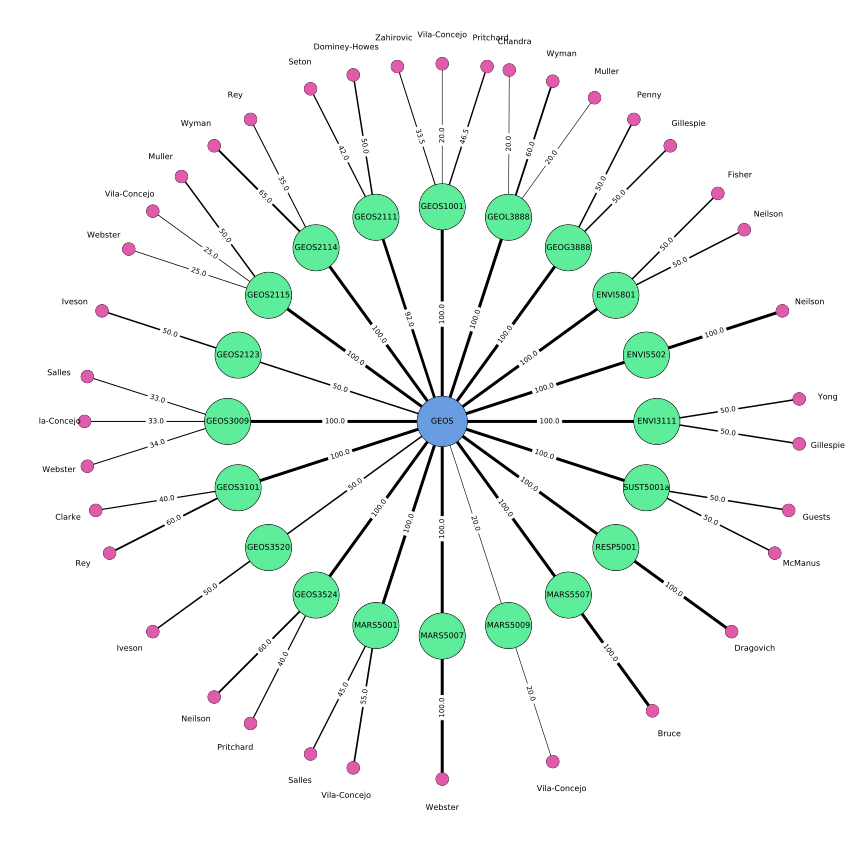

In [21]:
G1, pos1, unitpos1, staffpos1, nodelist1, staffname1, labeldict1 = createGraph(units1)
viewGraph(G1, pos1, unitpos1, staffpos1, nodelist1, staffname1, labeldict1, figname='semester1.pdf')

### Semester 2

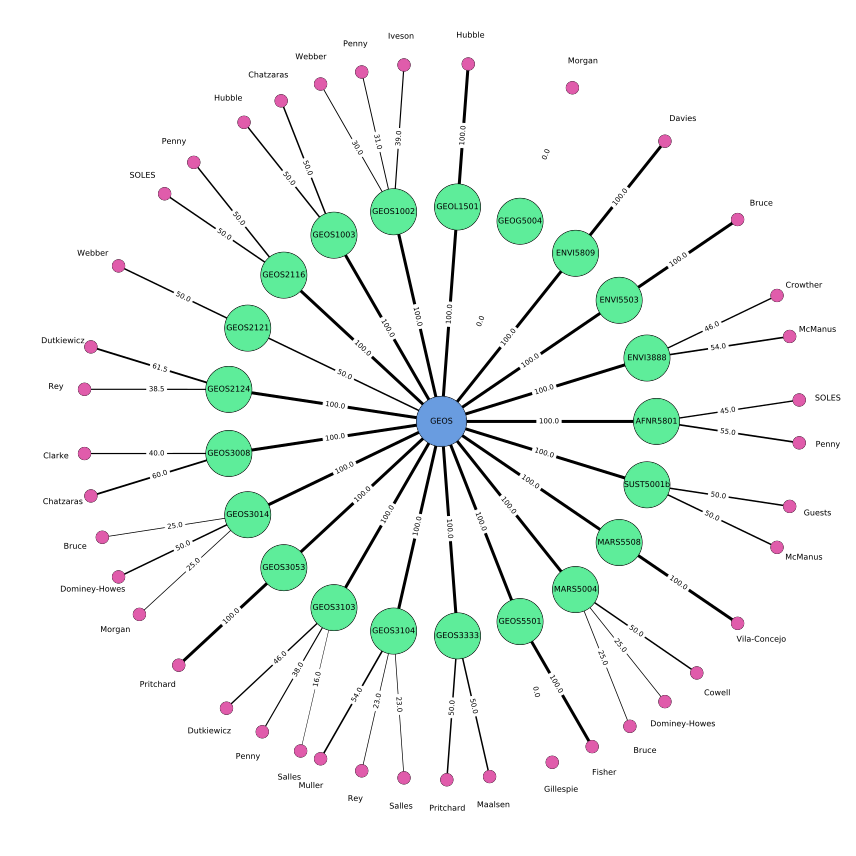

In [22]:
G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2 = createGraph(units2)
viewGraph(G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2, figname='semester2.pdf')

In [23]:
# Need to update GEOS2121 AFNR5801 GEOS1002

### Honours 

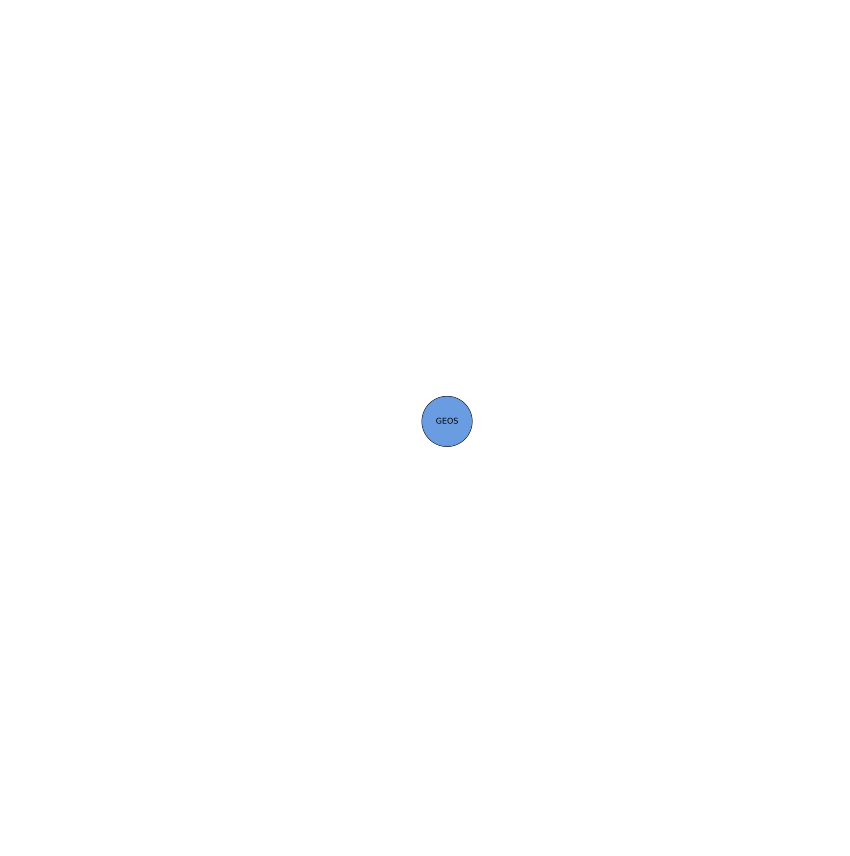

In [24]:
G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2 = createGraph(unitsH)
viewGraph(G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2)

### OLEs

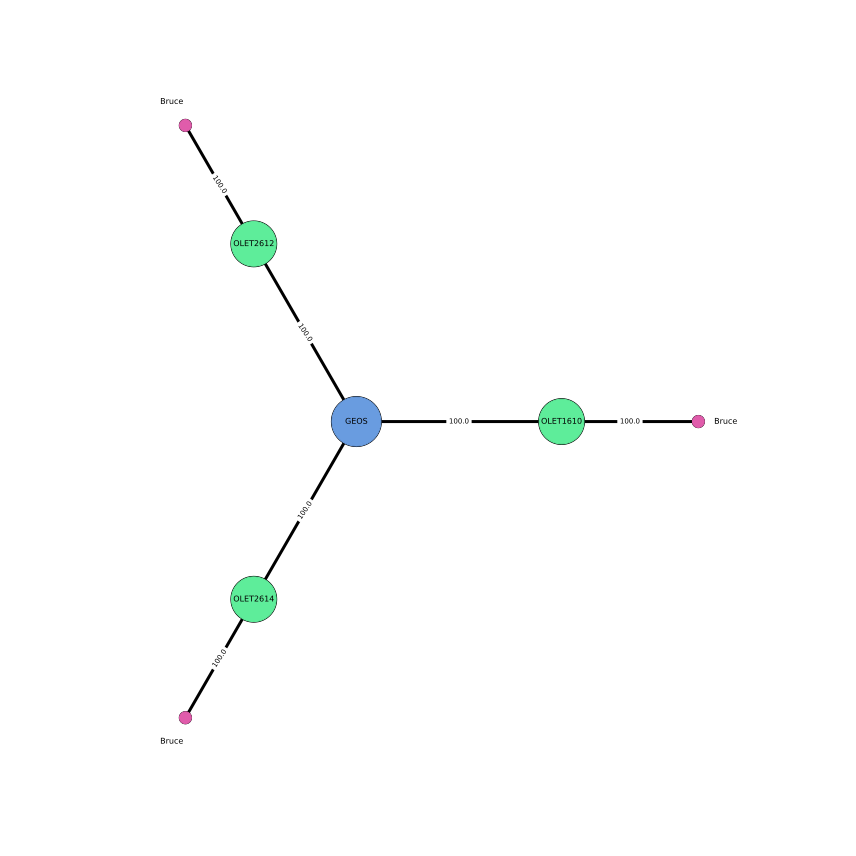

In [25]:
G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2 = createGraph(unitsO)
viewGraph(G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2)

### All units

In [26]:
def viewGraphAll(G, pos, unitpos, staffpos, nodelist, staffname, labeldict):
    
    fig, ax = plt.subplots(1,figsize=(16,16)) 

    margin=0.4
    fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
    ax.axis('equal')

    # pos,unitpos,staffpos,nodelist,staffname

    nx.draw_networkx_nodes(G,pos,
                           node_color='k',
                           node_size=100)
    nx.draw_networkx_nodes(G,pos,
                           node_color='#ea6f27',
                           node_size=90)
    nx.draw_networkx_nodes(G,pos,nodelist=nodelist,
                           node_color='k',
                           node_size=1300)
    nx.draw_networkx_nodes(G,pos,nodelist=nodelist,
                           node_color='#268bea',
                           node_size=1200)
    nx.draw_networkx_nodes(G,pos,nodelist=['GEOS'],
                           node_color='k',
                           node_size=2500)
    nx.draw_networkx_nodes(G,pos,nodelist=['GEOS'],
                           node_color='#d325ea',
                           node_size=2400)
    edges = G.edges()

    weights = [G[u][v]['weight']*0.03 for u,v in edges]
    elabels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}

    nx.draw_networkx_edges(G, pos, width=weights, with_labels=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=elabels, font_size=7)
    nx.draw_networkx_labels(G, unitpos, font_size=6, labels=labeldict)
    nx.draw_networkx_labels(G, staffpos, font_size=6, labels=staffname)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.tight_layout()
    fig.savefig('school.pdf',dpi=300)
    plt.show()
    return

In [27]:
G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2 = createGraph(allunits)

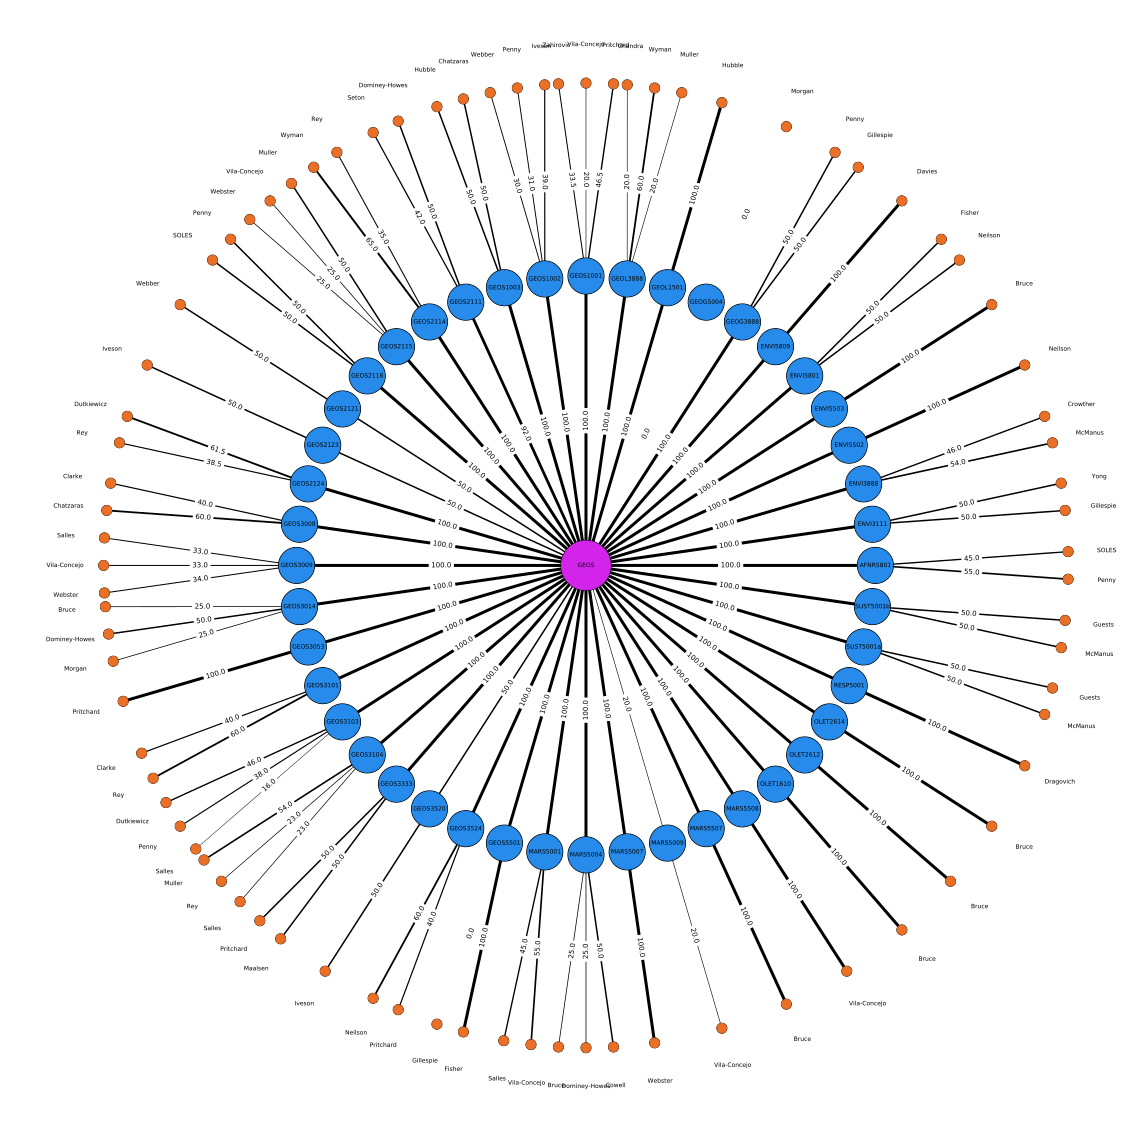

In [28]:
viewGraphAll(G2, pos2, unitpos2, staffpos2, nodelist2, staffname2, labeldict2)